# Introduction

In this repository, we are going to learn how to construct a yield curve with 3 famous methods, that is Principal Component Analysis, Nelson-Siegel model and Nelson-Siegel-Svenson model. This model is based on *Computational Actuarial Science with R* by Arthur Charpentier.

In [1]:
import pandas as pd # Creating DataFrame
import numpy as np # Vector Matrices
import matplotlib.pyplot as plt # Plotting

# PCA

Principal Component Analysis (PCA) is a method to reduce dimensionality of a data without losing any significance information.

In [2]:
df = pd.read_csv('data/FedYieldCurve.csv', index_col = 'Unnamed: 0')
df

,R_3M,R_6M,R_1Y,R_2Y,R_3Y,R_5Y,R_7Y,R_10Y
1981-12-31,12.92,13.90,14.32,14.57,14.64,14.65,14.67,14.59
1982-01-31,14.28,14.81,14.73,14.82,14.73,14.54,14.46,14.43
1982-02-28,13.31,13.83,13.95,14.19,14.13,13.98,13.93,13.86
1982-03-31,13.34,13.87,13.98,14.20,14.18,14.00,13.94,13.87
1982-04-30,12.71,13.13,13.34,13.78,13.77,13.75,13.74,13.62
...,...,...,...,...,...,...,...,...
2012-07-31,0.10,0.14,0.18,0.27,0.37,0.71,1.14,1.68
2012-08-31,0.11,0.14,0.18,0.26,0.34,0.67,1.12,1.72
2012-09-30,0.10,0.15,0.18,0.28,0.37,0.71,1.15,1.75
2012-10-31,0.09,0.14,0.18,0.27,0.36,0.67,1.08,1.65


In [3]:
u, s, vh = np.linalg.svd((df-df.mean()).values)

In [4]:
yield_curve = pd.DataFrame(data = {'level': u[:,0]*s[0],
                                        'slope':u[:,1]*s[1],
                                        'curvature':u[:,2]*s[2]}, index = df.index)
yield_curve

,level,slope,curvature
1981-12-31,-24.841725,-0.096847,-0.077912
1982-01-31,-25.754093,1.238945,-0.645961
1982-02-28,-23.765354,0.845435,-0.386518
1982-03-31,-23.836928,0.865805,-0.381666
1982-04-30,-22.574645,0.374954,-0.311248
...,...,...,...
2012-07-31,13.949964,0.805307,0.060413
2012-08-31,13.969484,0.811951,0.021757
2012-09-30,13.916946,0.770492,0.032725
2012-10-31,14.001006,0.853652,0.081933


<AxesSubplot: title={'center': 'Level'}>

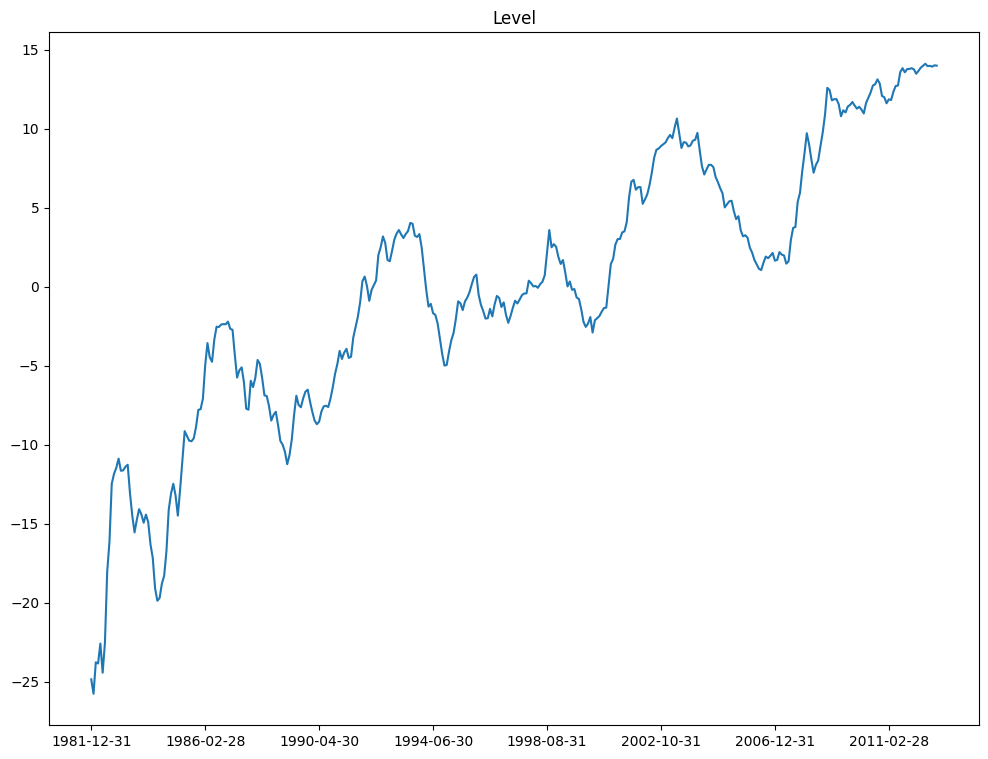

In [5]:
fig, ax = plt.subplots(figsize = (12,9))
plt.title('Level')
yield_curve.level.plot()

# Nelson - Siegel - Svennson Model

Let $s(t)$ be spot rate at time $t >0$. Nelson - Siegel - Svennson Model assumes taht the spot rates are governed by six paramaters according to the functional form:  
$$s(t, \tau) = \beta_0 + \beta_1 \left(\frac{1-\exp{\left(\frac{-\tau}{\lambda_1}\right)}}{\frac{\tau}{\lambda_1}}\right)+ \beta_2 \left(\frac{1-\exp{\left(-\frac{\tau}{\lambda_1}\right)}}{\frac{\tau}{\lambda_1}}-\exp{\left(-\frac{\tau}{\lambda_1}\right)} \right) + \beta_3 \left(\frac{1-\exp{\left(-\frac{\tau}{\lambda_2}\right)}}{\frac{\tau}{\lambda_2}}-\exp{\left(-\frac{\tau}{\lambda_2}\right)} \right)  $$ 
with $\tau$ is maturity of the bond

From equation above, we interest in estimating the set of parameter below: 
$$\mathbf{\beta} = \begin{bmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \\ \beta_3 \\ \lambda_1 \\ \lambda_2\end{bmatrix}$$

And we interest in minimizing the equation below:  
$$\min_\mathbf{\beta} (y(t) - \hat{y}(t, \beta))^2$$ 
Two methods are being used, first is the Spiral Optimization (SPO), and Differential Evolution (DE). 

In [6]:
df.tail()

,R_3M,R_6M,R_1Y,R_2Y,R_3Y,R_5Y,R_7Y,R_10Y
2012-07-31,0.10,0.14,0.18,0.27,0.37,0.71,1.14,1.68
2012-08-31,0.11,0.14,0.18,0.26,0.34,0.67,1.12,1.72
2012-09-30,0.10,0.15,0.18,0.28,0.37,0.71,1.15,1.75
2012-10-31,0.09,0.14,0.18,0.27,0.36,0.67,1.08,1.65
2012-11-30,0.07,0.12,0.16,0.26,0.35,0.70,1.13,1.72


## Spiral Optimization

In [7]:
def nss(beta, tau = [0.25, 0.5, 1, 2, 3, 5, 7, 10]):
    c1 = tau/beta[4] # tau / lambda 1
    c2 = tau/beta[5] # tau / lambda 2
    return beta[0] + beta[1]*((1-np.exp(-c1))/c1) + beta[2]*((1-np.exp(-c1))/c1 - np.exp(-c1)) + beta[3]*((1-np.exp(-c2))/c2 - np.exp(-c2))

In [8]:
def spo(y, max_iter = 1000):
    # Initial Guess
    beta = np.random.rand(4, 6)
    beta_star = beta[0]
    min_error = np.linalg.norm((y - nss(beta= beta_star)),2)
    k_star = 0
    
    # Rotation Matrix
    rot_matrix = np.zeros((6,6))
    rot_matrix[0,5] = 1 
    for k in range(5):
        rot_matrix[k+1,k] = 1
        
    # Update Algorithm 
    for n in range(max_iter):
        if n > k_star + 2*6:
            r = 0.5**(2*6)
        else : 
            r = 1
        for i in range(beta.shape[0]):
            new_error = np.linalg.norm(y - nss(beta= beta[i]),2)
            if min_error > new_error:
                min_error = new_error
                beta_star = beta[i]    
        
        # Update beta and beta star        
        for i in range(beta.shape[0]):
            beta[i] = beta_star + r*rot_matrix.dot(beta[i] - beta_star)
            
    return beta_star, min_error

In [14]:
error = []
params = []
for n in range(10):
    paramss, err = spo(y = df.iloc[-1].values, max_iter= 10000)
    params.append(paramss)
    error.append(err)

C:\Users\leona\AppData\Local\Temp\ipykernel_39016\227015860.py:4: RuntimeWarning: overflow encountered in exp
  return beta[0] + beta[1]*((1-np.exp(-c1))/c1) + beta[2]*((1-np.exp(-c1))/c1 - np.exp(-c1)) + beta[3]*((1-np.exp(-c2))/c2 - np.exp(-c2))
C:\Users\leona\AppData\Local\Temp\ipykernel_39016\227015860.py:4: RuntimeWarning: invalid value encountered in subtract
  return beta[0] + beta[1]*((1-np.exp(-c1))/c1) + beta[2]*((1-np.exp(-c1))/c1 - np.exp(-c1)) + beta[3]*((1-np.exp(-c2))/c2 - np.exp(-c2))


In [17]:
params

[array([ 1.72062176, -1.60380606,  0.88060138, -1.41647945,  3.09466322,
         0.78058435]),
 array([ 0.58747235, -0.91122013,  1.05011426,  0.68611624,  1.33802975,
         0.0532712 ]),
 array([ 0.61456548, -1.03117292,  1.75093057,  0.66213126,  1.40096374,
         0.32790927]),
 array([ 1.26365619, -1.38597286,  0.73788533,  0.33739919,  2.1758028 ,
         0.05849733]),
 array([ 1.27451896, -1.70748019, -0.21568271,  1.93766019,  1.8310169 ,
         0.30136622]),
 array([ 0.58202404, -0.53017322,  1.85861569, -0.70610772,  1.80964515,
         0.36729517]),
 array([ 0.76669993, -0.72475981,  1.37720429, -0.65812386,  1.91720792,
         0.48955757]),
 array([ 0.90195664, -1.13759768,  0.54653882,  0.33845309,  1.97089676,
         0.17394008]),
 array([0.23259575, 0.60363517, 0.27669622, 0.80942984, 0.035331  ,
        0.5213782 ]),
 array([ 1.1443113 , -1.1229421 ,  0.09562721,  0.02428459,  1.29121715,
         1.08566091])]

In [15]:
error

[0.5412789381922334,
 1.2636151884617337,
 1.251611393120279,
 0.8244435335256716,
 0.9018405824942126,
 1.1624443231470762,
 1.0290913791810836,
 1.0372069226458278,
 1.8434100132147822,
 0.9531860503736161]

In [13]:
spo(y = df.iloc[-1].values, max_iter= 1000)

C:\Users\leona\AppData\Local\Temp\ipykernel_39016\227015860.py:4: RuntimeWarning: overflow encountered in exp
  return beta[0] + beta[1]*((1-np.exp(-c1))/c1) + beta[2]*((1-np.exp(-c1))/c1 - np.exp(-c1)) + beta[3]*((1-np.exp(-c2))/c2 - np.exp(-c2))
C:\Users\leona\AppData\Local\Temp\ipykernel_39016\227015860.py:4: RuntimeWarning: invalid value encountered in subtract
  return beta[0] + beta[1]*((1-np.exp(-c1))/c1) + beta[2]*((1-np.exp(-c1))/c1 - np.exp(-c1)) + beta[3]*((1-np.exp(-c2))/c2 - np.exp(-c2))


(array([ 0.92992213, -1.89036717,  2.14610362,  0.0227778 ,  0.98705961,
         1.48589169]),
 1.2994553748285793)